In [1]:
from os.path import join, dirname, abspath

import matplotlib.pyplot as plt

from pypsa import Network

from pyggrid.postprocessing.utils import *

### Parameters

In [2]:
year = 2018

techs = ["ccgt", "pv_residential_national", "pv_utility_national",
         "wind_offshore_national", "wind_onshore_national",
         "AC", "DC", "Li-ion"]
techs_generic = ["ccgt", "pv_residential", "pv_utility",
                 "wind_offshore", "wind_onshore",
                 "AC", "DC", "Li-ion"]

regions_dict = {'Iberia': ['ES', 'PT'],
                'Central West': ['NL', 'BE', 'LU', 'FR', 'DE'],
                'Nordics': ['DK', 'NO', 'SE', 'FI'],
                'British Isles': ['GB', 'IE'],
                'Central South': ['CH', 'IT', 'AT', 'SI'],
                'East': ['PL', 'HU', 'CZ', 'SK', 'LV', 'LT', 'EE'],
                'South': ['HR', 'GR', 'BG', 'RO'],
                'NA': ["DZ", "EG", "MA", "LY", "TN"],
                'GLIS': ["IS"]}

cases = ["EU", "EUGLIS", "EUGLIS_owp1.5", "EUNA", "EUNAGLIS_owp1.5"]

### Loading solved nets

In [3]:
nets = dict.fromkeys(cases)
for case in cases:
    output_dir = f'../../../output/from_pan/{case}_{year}/'
    net = Network()
    net.import_from_csv_folder(output_dir)
    nets[case] = net

INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units


### Compute costs

In [7]:
costs = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=cases)
for case in cases:
    net = nets[case]
    cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
    costs.loc["Generation", case] = get_generators_cost(net).sum()
    costs.loc["Transmission", case] = get_links_capex(net).sum()
    costs.loc["Storage", case] = get_storage_cost(net).sum()
costs.loc["Total"] = costs.sum().round(3)
costs.to_csv("costs.csv")
print(costs)

                   EU   EUGLIS EUGLIS_owp1.5     EUNA EUNAGLIS_owp1.5
Generation    65.7902  65.7902       73.2331  63.7778         69.4581
Transmission     6.28     6.28           6.7      7.8             8.9
Storage       3.63129  3.63118       5.92725  3.81827         6.90588
Total          75.702   75.701         85.86   75.396          85.264


### Load

In [21]:
print(net.loads_t.p.sum(axis=1).max())

513.06693


### Capacities

#### Total capacities

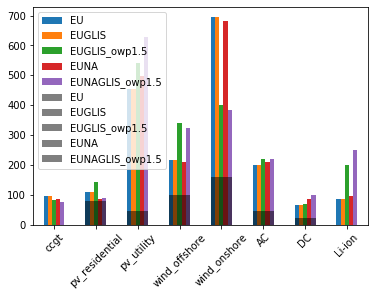

In [41]:
capacities_df = pd.DataFrame(columns=cases, index=techs_generic)
capacities_init_df = pd.DataFrame(columns=cases, index=techs_generic)
for case in cases:
    net = nets[case]
    capacities = pd.concat([get_generators_capacity(net)["final"],
                            get_links_capacity(net)["new [TWkm]"] + get_links_capacity(net)["init [TWkm]"],
                            get_storage_energy_capacity(net)["new [GWh]"]])
    for tech in techs_generic:
        capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum().round()
    # capacities_df[case] = capacities[techs].round().values
    capacities = pd.concat([get_generators_capacity(net)["init"],
                            get_links_capacity(net)["init [TWkm]"],
                            get_storage_power_capacity(net)["init [GW]"]])
    capacities_init_df[case] = capacities[techs].round().values
capacities_df.round(3).to_csv("capacities.csv")
ax1 = capacities_df.plot(kind="bar")
capacities_init_df.plot(ax=ax1, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.savefig(f"capacities_{year}.png", bbox_inches="tight")

### Potential

In [79]:
wind_on_generators = net.generators[net.generators.type == "wind_onshore_national"]
wind_potential = wind_on_generators.p_nom_max.sort_values()
wind_potential.index = [idx.split(" ")[0] for idx in wind_potential.index]
#print(wind_potential)
#wind_potential.plot(kind='bar')
#plt.xticks(rotation=90)

wind_profiles_produced = net.generators_t.p[wind_on_generators.index].mean()/wind_on_generators.p_nom_opt
wind_p_max_pu = net.generators_t.p_max_pu[wind_on_generators.index].mean().sort_values()

#print(wind_p_max_pu)

for case in cases:
    net = nets[case]
    ccgt_generators = net.generators[net.generators.type == "ccgt"]
    ccgt_cap = ccgt_generators.p_nom_opt.sort_values()
    ccgt_cap.index = [idx.split(" ")[0] for idx in wind_potential.index]
    # print(ccgt_cap)


    ccgt_produced = (net.generators_t.p[ccgt_generators.index].mean()/ccgt_generators.p_nom_opt).sort_values()
    # wind_p_max_pu = net.generators_t.p_max_pu[wind_on_generators.index].mean().sort_values()

    print(ccgt_produced)


FR Gen ccgt    0.050917
NO Gen ccgt    0.053682
BE Gen ccgt    0.053824
SE Gen ccgt    0.054188
FI Gen ccgt    0.055297
NL Gen ccgt    0.059062
EE Gen ccgt    0.059654
IT Gen ccgt    0.061105
LV Gen ccgt    0.061567
CZ Gen ccgt    0.064391
PL Gen ccgt    0.066913
LT Gen ccgt    0.068329
GB Gen ccgt    0.069414
DE Gen ccgt    0.070018
LU Gen ccgt    0.073791
DK Gen ccgt    0.074664
GR Gen ccgt    0.087962
BG Gen ccgt    0.088534
RO Gen ccgt    0.089964
HU Gen ccgt    0.092490
HR Gen ccgt    0.092897
SK Gen ccgt    0.093196
AT Gen ccgt    0.093219
SI Gen ccgt    0.093240
IE Gen ccgt    0.093291
CH Gen ccgt    0.101101
PT Gen ccgt    0.129992
ES Gen ccgt    0.132805
dtype: float64
NO Gen ccgt    0.061919
FI Gen ccgt    0.091022
FR Gen ccgt    0.092419
BG Gen ccgt    0.093927
GB Gen ccgt    0.103378
SE Gen ccgt    0.110559
EE Gen ccgt    0.125654
LT Gen ccgt    0.142289
LV Gen ccgt    0.142941
BE Gen ccgt    0.152636
PT Gen ccgt    0.169557
ES Gen ccgt    0.173466
IE Gen ccgt    0.175287
N

#### Emissions

In [8]:
# CCGT generation
for case in cases:
    net = nets[case]
    ccgt_generators = net.generators[net.generators.type == "ccgt"]
    ccgt_cap = ccgt_generators.p_nom_opt.sort_values()
    ccgt_cap.index = [idx.split(" ")[0] for idx in wind_potential.index]
    # print(ccgt_cap)


    ccgt_produced = net.generators_t.p[ccgt_generators.index]
    co2_emissions = ccgt_produced.sum().sum()*net.carriers.loc["gas", "co2_emissions"]
    print(co2_emissions)
print(net.global_constraints.constant.values[0] * 1e-3)    
from pyggrid.network.globals.functionalities import get_reference_emission_levels_for_region
#add_co2_budget_global(net, ["EU"], 0.9, 1990)

NHoursPerYear = 8760.
co2_techs = ['ccgt']
region = ["EU"]
co2_reference_kt = get_reference_emission_levels_for_region(region, co2_reduction_refyear)
co2_budget = co2_reference_kt * (1 - co2_reduction_share) * len(network.snapshots) / NHoursPerYear


NameError: name 'wind_potential' is not defined

#### Geographical distribution of capacities

##### Map of regions

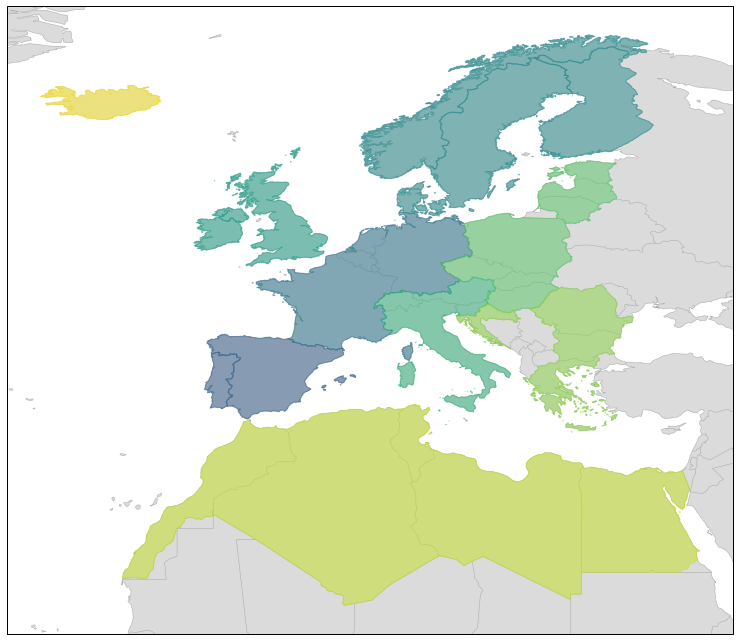

In [20]:
from shapely.ops import unary_union
from pyggrid.data.geographics import get_shapes
from pyggrid.data.geographics.plot import display_polygons

region_shapes = []
region_centroids = []
regions = list(regions_dict.keys())
for region in regions:
    # print(net.buses[net.buses.index.isin(regions_dict[region])].region.values)
    # region_shape = unary_union(net.buses[net.buses.index.isin(regions_dict[region])].region.values)
    region_shape = unary_union(get_shapes(regions_dict[region], "onshore")["geometry"].values)
    region_shapes += [region_shape]
    region_centroids += [region_shape.centroid]
ax = display_polygons(region_shapes, show=False)
#for region, centroid in zip(regions, region_centroids):
#    plt.text(centroid.x, centroid.y, region, fontsize=10)
plt.savefig(f"european_map.png", bbox_inches="tight", figsize=(12, 12), dpi=300)

#### Capacities

In [9]:
# Compute

storage_per_region = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
ccgt_per_region = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pv_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pv_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pvr_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pvr_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
won_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
won_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
woff_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
woff_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)

for case in cases:
    net = nets[case]
    capacities_df = pd.DataFrame(0., columns=regions_dict.keys(), 
                                 index=["ccgt", "Li-ion", "pv_residential", 
                                        "pv_utility", "wind_onshore", "wind_offshore"])
    for region in regions_dict.keys():
        # Li-ion
        df = get_storage_power_capacity(net, regions_dict[region], ["Li-ion"])
        if 'Li-ion' in df.index:
            storage_per_region.loc[region, case] = df.loc["Li-ion", "new [GW]"]
        capacities_df.loc["Li-ion", region] = storage_per_region.loc[region, case]
        
        df = get_generators_capacity(net, regions_dict[region], ["ccgt"])
        # CCGT
        if 'ccgt' in df.index:
            ccgt_per_region.loc[region, case] = df.loc["ccgt", "new"]
        capacities_df.loc["ccgt", region] = ccgt_per_region.loc[region, case]

        # PV utility
        df = get_generators_capacity(net, regions_dict[region], ["pv_utility_national", "pv_utility_noneu"])
        if 'pv_utility_national' in df.index:
            pv_per_region_init.loc[region, case] = df.loc["pv_utility_national", "init"]
            pv_per_region_final.loc[region, case] = df.loc["pv_utility_national", "final"]
        if 'pv_utility_noneu' in df.index:
            pv_per_region_init.loc[region, case] = df.loc["pv_utility_noneu", "init"]
            pv_per_region_final.loc[region, case] = df.loc["pv_utility_noneu", "final"]
        capacities_df.loc["pv_utility", region] = pv_per_region_final.loc[region, case]

        
        # PV residential
        df = get_generators_capacity(net, regions_dict[region], ["pv_residential_national"])
        if 'pv_residential_national' in df.index:
            pvr_per_region_init.loc[region, case] = df.loc["pv_residential_national", "init"]
            pvr_per_region_final.loc[region, case] = df.loc["pv_residential_national", "final"]
        capacities_df.loc["pv_residential", region] = pvr_per_region_final.loc[region, case]

        # Wind onshore
        df = get_generators_capacity(net, regions_dict[region], ["wind_onshore_national", "wind_onshore_noneu"])
        if 'wind_onshore_national' in df.index:
            won_per_region_init.loc[region, case] = df.loc["wind_onshore_national", "init"]
            won_per_region_final.loc[region, case] = df.loc["wind_onshore_national", "final"]
        if 'wind_onshore_noneu' in df.index:
            won_per_region_init.loc[region, case] = df.loc["wind_onshore_noneu", "init"]
            won_per_region_final.loc[region, case] = df.loc["wind_onshore_noneu", "final"]
        capacities_df.loc["wind_onshore", region] = won_per_region_final.loc[region, case]

        # Wind offshore
        df = get_generators_capacity(net, regions_dict[region], ["wind_offshore_national", "wind_offshore_noneu"])
        if 'wind_offshore_national' in df.index:
            woff_per_region_init.loc[region, case] = df.loc["wind_offshore_national", "init"]
            woff_per_region_final.loc[region, case] = df.loc["wind_offshore_national", "final"]
        if 'wind_offshore_noneu' in df.index:
            woff_per_region_init.loc[region, case] = df.loc["wind_offshore_noneu", "init"]
            woff_per_region_final.loc[region, case] = df.loc["wind_offshore_noneu", "final"]
        capacities_df.loc["wind_offshore", region] = woff_per_region_final.loc[region, case]

        capacities_df.round(3).to_csv(f"capacities_per_region_{case}.csv")

In [ ]:
# Save
storage_per_region.round(3).to_csv("liion.csv")
ccgt_per_region.round(3).to_csv("ccgt.csv")
pv_per_region_final.round(3).to_csv("pv_utility.csv")
pvr_per_region_final.round(3).to_csv("pv_residential.csv")  
won_per_region_final.round(3).to_csv("wind_onshore.csv")  
woff_per_region_final.round(3).to_csv("wind_offshore.csv")

<Figure size 432x288 with 0 Axes>

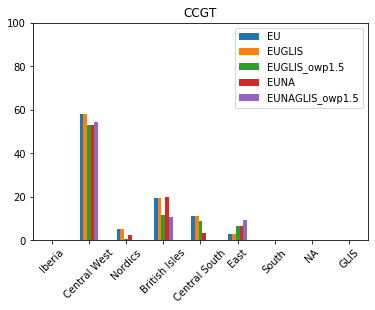

<Figure size 432x288 with 0 Axes>

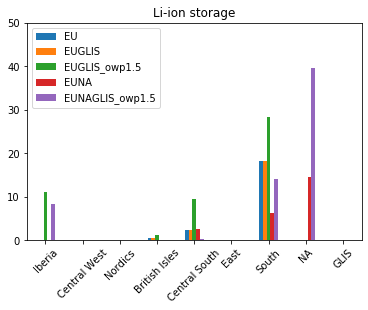

<Figure size 432x288 with 0 Axes>

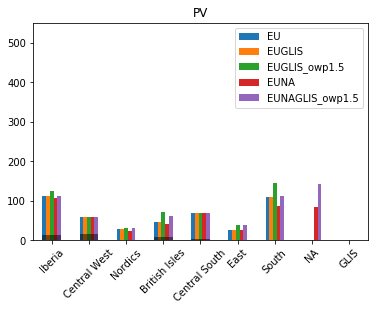

<Figure size 432x288 with 0 Axes>

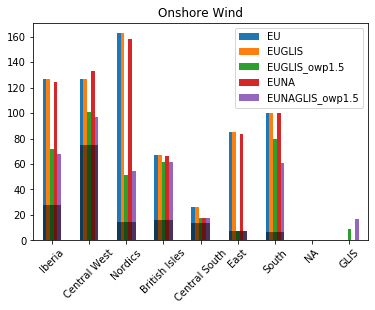

<Figure size 432x288 with 0 Axes>

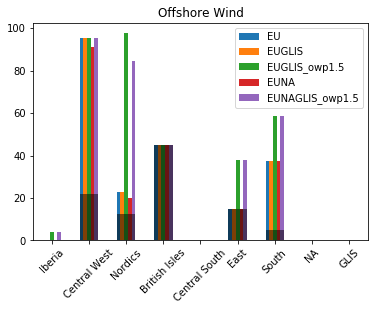

In [10]:
# Plot
plt.figure()
ccgt_per_region.plot(kind="bar")
plt.xticks(rotation="45")
plt.ylim([0, 100])
plt.title("CCGT")
plt.savefig(f"ccgt_capacities_{year}.png", bbox_inches="tight")

plt.figure()
storage_per_region.plot(kind="bar")
plt.xticks(rotation="45")
plt.ylim([0, 50])
plt.title("Li-ion storage")
plt.savefig(f"storage_capacities_{year}.png", bbox_inches="tight")

plt.figure()
ax = pv_per_region_final.plot(kind="bar")
pv_per_region_init.plot(ax=ax, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.legend(cases)
plt.ylim([0, 550])
plt.title("PV")
plt.savefig(f"pv_capacities_{year}.png", bbox_inches="tight")

plt.figure()
ax1 = won_per_region_final.plot(kind="bar")
won_per_region_init.plot(ax=ax1, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.legend(cases)
# plt.ylim([0, 225])
plt.title("Onshore Wind")
plt.savefig(f"windon_capacities_{year}.png", bbox_inches="tight")

plt.figure()
ax2 = woff_per_region_final.plot(kind="bar")
woff_per_region_init.plot(ax=ax2, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.legend(cases)
# plt.ylim([0, 100])
plt.title("Offshore Wind")
plt.savefig(f"windoff_capacities_{year}.png", bbox_inches="tight")

### Transmission

In [67]:
# Capacity overall
capacities_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net)
    capacities_df["init"] = capacities["init [TWkm]"]
    capacities_df[case] = capacities["new [TWkm]"]
print(f"Added capacity:\n {capacities_df}")

# In Europe
capacities_eu_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
outside_nodes = regions_dict["GLIS"] + regions_dict["NA"]
print(outside_nodes)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net, outside_nodes)
    capacities_eu_df["init"] = capacities["init [TWkm]"]
    capacities_eu_df[case] = capacities["new [TWkm]"]
print(f"Added capacity:\n {capacities_eu_df}")

Added capacity:
      init  EUGLIS  EUGLIS_owp1.5
AC  45.04  155.42         175.07
DC  23.15   44.17          44.76
['GL', 'IS', 'DZ', 'EG', 'MA', 'LY', 'TN']
Added capacity:
      init  EUGLIS  EUGLIS_owp1.5
AC  45.04  155.42         175.07
DC  23.15   44.17          36.87


In [5]:
# Maps of flows
from pyggrid.postprocessing.plotly import SizingPlotly

for case in cases:
    net = nets[case]
    sp = SizingPlotly(net)
    #fig = sp.plot_topology()
    #fig = sp.plot_capacity("init")
    #fig.show()
    fig = sp.plot_capacity("final")
    #fig.show()
    fig.write_image(f"transmission_capacity_{case}.png", dpi=300)
    # fig.write_html(f"{case}_topology_heatmap.html", auto_open=True)

TypeError: write_image() got an unexpected keyword argument 'dpi'

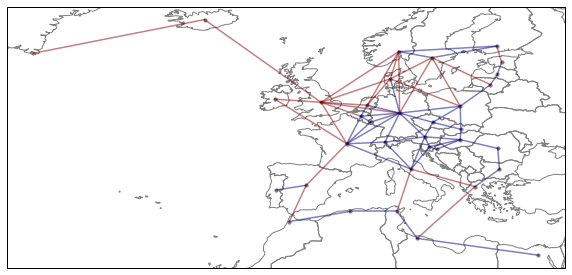

In [16]:
from pyggrid.data.topologies.core.plot import plot_topology

for case in cases:
    net = nets[case]
    plot_topology(net.buses, net.links)